In [1]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
import api as pyq 
import importlib
import os
import h5py
import pandas as pd
import pdb
import pyscf
import numpy as np
import pyqmc
import scipy

import jastrowspin
import matplotlib.pyplot as plt
from pyscf.scf.hf import dump_scf_summary
from concurrent.futures import ProcessPoolExecutor
from pyscf.scf.chkfile import dump_scf
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py


In [14]:
# Wavefunction generation
from pyscf import lib, gto, scf
from pyscf import gto, mp, mcscf
def H2_casci(scf_checkfile, ci_checkfile):
    mol = gto.M(
        atom="H 0. 0. 0.0; H 0. 0. 1.4",
        basis=f"ccecpccpvqz",
        unit="bohr",
        charge=0,
        spin=0,
        verbose=1,
    )
    mf = scf.UHF(mol).run()
    mf.chkfile = scf_checkfile
    mf.kernel()
    mc = mcscf.CASCI(mf, 3,2)
    # mc.fcisolver.nroots = 4
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff    
    return mol, mf, mc

In [15]:
scf_checkfile = 'rohf.chk'
ci_checkfile = 'casci.chk'
for fname in [scf_checkfile, ci_checkfile]:
    if os.path.isfile(fname):
        os.remove(fname)
mol, mf, mcc = H2_casci(scf_checkfile, ci_checkfile)
# mol, mf, mcc = HF_casci(scf_checkfile, ci_checkfile)

dict_keys(['mol', '_scf', 'verbose', 'stdout', 'max_memory', 'ncas', 'nelecas', '_ncore', 'fcisolver', 'frozen', 'extrasym', 'e_tot', 'e_cas', 'ci', 'mo_coeff', 'mo_energy', 'mo_occ', 'converged'])


In [16]:
mcc.ci

FCIvector([[ 9.99414547e-01,  3.80945275e-15,  4.95318477e-03],
           [ 4.29717647e-15, -2.21215301e-02,  6.82140535e-16],
           [ 4.95318477e-03,  6.62509855e-16, -2.51422548e-02]])

In [21]:
import importlib, bosonslater
modules = [bosonslater] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
    
from bosonwftools import generate_boson_wf
wf, to_opt = generate_boson_wf(mol, mf, mc = mcc)

> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/bosonslater.py(126)__init__()
    124         import pdb
    125         pdb.set_trace()
--> 126         num_det = mc.ci.shape[0] * mc.ci.shape[1]
    127 
    128         # for i in range(mc.ci.shape[0]):



ipdb>  c


In [ ]:
# def fixed_initial_guess(mol, nconfig, r=1.0):


#     """
#     Ideally works for H2 molecule with H-H aligned over z-axis and H1 at origin, H2 at [0,0,2]
#     :parameter mol: A PySCF-like molecule object. Should have atom_charges(), atom_coords(), and nelec
#     :parameter nconfig: How many configurations to generate.
#     :parameter r: How far from the atoms to distribute the electrons
#     :returns: (nconfig,nelectrons,3) array of electron positions randomly distributed near the atoms.
#     :rtype: ndarray

#     """
#     from pyqmc.coord import OpenConfigs, PeriodicConfigs

#     epos = np.zeros((nconfig, np.sum(mol.nelec), 3))
#     wts = mol.atom_charges()
#     wts = wts / np.sum(wts)
#     ind0 = 0
#     for s in [0, 1]:
#         neach = np.array(
#             np.floor(mol.nelec[s] * wts), dtype=int
#         )  # integer number of elec on each atom
#         nleft = (
#             mol.nelec[s] * wts - neach
#         )  # fraction of electron unassigned on each atom
#         nassigned = np.sum(neach)  # number of electrons assigned
#         totleft = int(mol.nelec[s] - nassigned)  # number of electrons not yet assigned
#         # 
#         max = 3
#         min = -1 
#         if ind0 > 0:
#             max = -1
#             min = max
#         epos[:, ind0, :] = np.linspace([-0.1,-0.1+ind0,min], [-0.1,-0.1+ind0,max], num=nconfig)
#         ind0 += 1
#     #     np.repeat(
#     #         mol.atom_coords(), neach, axis=0
#     #     )  # assign core electrons
#     #     if totleft > 0:
#     #         bins = np.cumsum(nleft) / totleft
#     #         inds = np.argpartition(
#     #             np.random.random((nconfig, len(wts))), totleft, axis=1
#     #         )[:, :totleft]
#     #         epos[:, ind0 + nassigned : ind0 + mol.nelec[s], :] = mol.atom_coords()[
#     #             inds
#     #         ]  # assign remaining electrons

#     # epos += r * np.random.randn(*epos.shape)  # random shifts from atom positions
#     # epos = np.linspace(0, 2, num=nconfig)
#     # print(epos)
#     if hasattr(mol, "a"):
#         epos = PeriodicConfigs(epos, mol.lattice_vectors())
#     else:
#         epos = OpenConfigs(epos)
    
#     return epos

In [20]:
import mc 
nconfig = 2000
configs = mc.fixed_initial_guess(mol, nconfig)
x = configs.configs[:,0][:,2] # fixed electron is 1, z coordinate

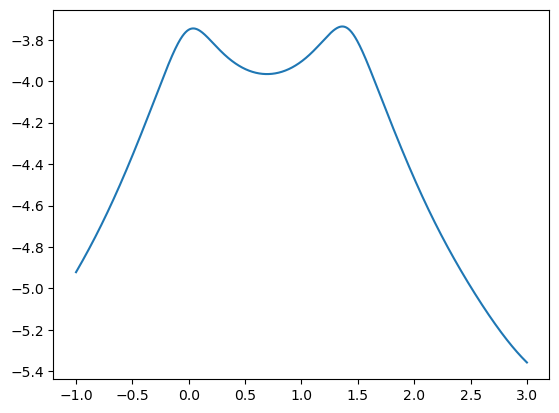

In [22]:
s, v = wf.recompute(configs)
plt.plot(x, v)

In [23]:
e = 0
g, _, _ = wf.gradient_value(e, configs.electron(e))
g_num = np.gradient(v, x) 

In [24]:
g.shape

(3, 2000)

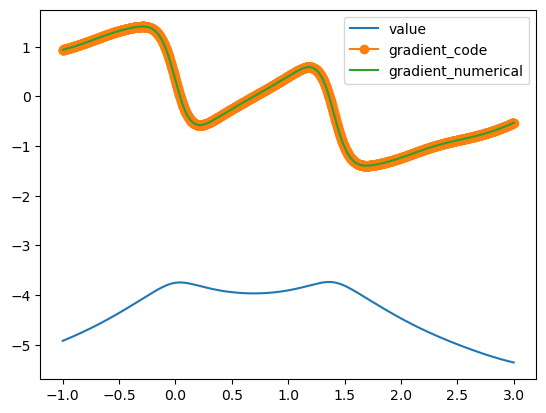

In [25]:
# plt.plot(x, v)
plt.plot(x, v, label='value')
plt.plot(x, g[2], '-o', label='gradient_code')
plt.plot(x, g_num, label='gradient_numerical')
plt.legend()